##**1**. **Data** **Preprocessing** **and** **Augmentation**

In [1]:
#Install Required Libraries
!pip install tensorflow pillow

In [3]:
from google.colab import files
import zipfile
import os

# Step 1: Upload ZIP file
uploaded = files.upload()

# Step 2: Get actual uploaded file name
uploaded_filename = list(uploaded.keys())[0]

# Step 3: Create full path
zip_path = os.path.join("/content", uploaded_filename)

# Step 4: Extract it
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/data")

print(f"Successfully extracted {uploaded_filename} to /content/data")

Saving Dataset.zip to Dataset (1).zip
Successfully extracted Dataset (1).zip to /content/data


In [4]:
#Import required libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define Directory Paths
train_dir = "/content/data/images.cv_jzk6llhf18tm3k0kyttxz/data/train"
val_dir = "/content/data/images.cv_jzk6llhf18tm3k0kyttxz/data/val"
test_dir = "/content/data/images.cv_jzk6llhf18tm3k0kyttxz/data/test"

# Set Image Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data Augmentation for Training Set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,           # rotate image up to 20 degrees
    zoom_range=0.2,              # zoom in/out by 20%
    width_shift_range=0.2,       # shift image left/right
    height_shift_range=0.2,      # shift image up/down
    horizontal_flip=True,        # flip image horizontally
    fill_mode='nearest'          # fill empty pixels after rotation/shift
)

# No Augmentation for Validation/Test, only Rescale
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create Data Generators
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'  # for multiclass classification
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False   # important for evaluation
)


Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.


##**2**. **Model** **Training**

In [5]:
#1. CNN Model from Scratch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,Input

model_scratch = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(11, activation='softmax') # 11 classes
])

model_scratch.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
#Common Function to Load and Fine-tune Models
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, NASNetMobile, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input

def build_model(base_model_class, input_shape=(224, 224, 3), num_classes=11):
    base_model = base_model_class(include_top=False, input_tensor=Input(shape=input_shape), weights='imagenet')
    base_model.trainable = False  # Freeze initial layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [7]:
#Build Models
vgg_model = build_model(VGG16)
resnet_model = build_model(ResNet50)
mobilenet_model = build_model(MobileNetV2)
nasnetmobile_model = build_model(NASNetMobile)
efficientnet_model = build_model(EfficientNetB0, input_shape=(224, 224, 3))  # Explicit input shape

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/tmp/ipython-input-539464841.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = base_model_class(include_top=False, input_tensor=Input(shape=input_shape), weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [8]:
#3. Model Training + Saving Best Model
#1. VGG16 Model Training
from tensorflow.keras.callbacks import EarlyStopping
vgg_early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

vgg_history = vgg_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[vgg_early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 113s 504ms/step - accuracy: 0.2818 - loss: 2.1151 - val_accuracy: 0.6593 - val_loss: 1.3916
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 87s 445ms/step - accuracy: 0.5804 - loss: 1.3777 - val_accuracy: 0.7674 - val_loss: 0.9458
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 87s 443ms/step - accuracy: 0.6857 - loss: 1.0301 - val_accuracy: 0.8379 - val_loss: 0.7032
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 87s 444ms/step - accuracy: 0.7383 - loss: 0.8573 - val_accuracy: 0.8663 - val_loss: 0.5639
Epoch 5/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 88s 449ms/step - accuracy: 0.7770 - loss: 0.7074 - val_accuracy: 0.8672 - val_loss: 0.5064
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 88s 450ms/step - accuracy: 0.8070 - loss: 0.6261 - val_accuracy: 0.9048 - val_loss: 0.3883
Epoch 7/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 88s 449ms/step - accuracy: 0.8168 - loss: 0.5699 - val_accuracy: 0.9185 - val_loss: 0.3670
Epoch 8/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 87s 443ms/step - accuracy: 0.8312 - loss: 

In [9]:
#2. ResNet50 Model Training
resnet_early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

resnet_history = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[resnet_early_stop]
)

Epoch 1/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 103s 462ms/step - accuracy: 0.1447 - loss: 2.4044 - val_accuracy: 0.1712 - val_loss: 2.2653
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 397ms/step - accuracy: 0.1688 - loss: 2.2827 - val_accuracy: 0.1676 - val_loss: 2.2132
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 398ms/step - accuracy: 0.1614 - loss: 2.2412 - val_accuracy: 0.1841 - val_loss: 2.1633
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 398ms/step - accuracy: 0.1910 - loss: 2.1944 - val_accuracy: 0.2042 - val_loss: 2.1210
Epoch 5/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 79s 403ms/step - accuracy: 0.1805 - loss: 2.1892 - val_accuracy: 0.1969 - val_loss: 2.1026
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 398ms/step - accuracy: 0.2020 - loss: 2.1579 - val_accuracy: 0.2079 - val_loss: 2.0527
Epoch 7/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 401ms/step - accuracy: 0.2162 - loss: 2.1291 - val_accuracy: 0.2097 - val_loss: 2.0700
Epoch 8/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 399ms/step - accuracy: 0.2051 - loss: 

In [10]:
#3. MobileNet Model Training
mobilenet_early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

mobilenet_history = mobilenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[mobilenet_early_stop]
)

Epoch 1/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 113s 497ms/step - accuracy: 0.6097 - loss: 1.2354 - val_accuracy: 0.9487 - val_loss: 0.1780
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 72s 371ms/step - accuracy: 0.9119 - loss: 0.2849 - val_accuracy: 0.9634 - val_loss: 0.1055
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 72s 371ms/step - accuracy: 0.9373 - loss: 0.1937 - val_accuracy: 0.9661 - val_loss: 0.0880
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 72s 370ms/step - accuracy: 0.9483 - loss: 0.1567 - val_accuracy: 0.9744 - val_loss: 0.0587
Epoch 5/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 74s 381ms/step - accuracy: 0.9592 - loss: 0.1273 - val_accuracy: 0.9799 - val_loss: 0.0534
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 73s 373ms/step - accuracy: 0.9608 - loss: 0.1177 - val_accuracy: 0.9808 - val_loss: 0.0588
Epoch 7/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 72s 371ms/step - accuracy: 0.9648 - loss: 0.1068 - val_accuracy: 0.9753 - val_loss: 0.0540
Epoch 8/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 73s 374ms/step - accuracy: 0.9644 - loss: 

In [11]:
#4. NASNetMobile Model Training
from tensorflow.keras.callbacks import EarlyStopping
nasnet_early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

nasnet_history = nasnetmobile_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[nasnet_early_stop]
)

Epoch 1/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 181s 712ms/step - accuracy: 0.5079 - loss: 1.4903 - val_accuracy: 0.8965 - val_loss: 0.3770
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 394ms/step - accuracy: 0.8334 - loss: 0.5150 - val_accuracy: 0.9396 - val_loss: 0.2310
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.8783 - loss: 0.3781 - val_accuracy: 0.9405 - val_loss: 0.1858
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 76s 391ms/step - accuracy: 0.8962 - loss: 0.3115 - val_accuracy: 0.9432 - val_loss: 0.1763
Epoch 5/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 394ms/step - accuracy: 0.9131 - loss: 0.2514 - val_accuracy: 0.9560 - val_loss: 0.1444
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.9256 - loss: 0.2279 - val_accuracy: 0.9487 - val_loss: 0.1450
Epoch 7/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 76s 390ms/step - accuracy: 0.9103 - loss: 0.2441 - val_accuracy: 0.9570 - val_loss: 0.1328
Epoch 8/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 76s 390ms/step - accuracy: 0.9300 - loss: 

In [12]:
#5. EfficientNetB0 Model Training
efficientnet_early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

efficientnet_history = efficientnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[efficientnet_early_stop]
)

Epoch 1/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 125s 515ms/step - accuracy: 0.1544 - loss: 2.3602 - val_accuracy: 0.1712 - val_loss: 2.3132
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 73s 374ms/step - accuracy: 0.1717 - loss: 2.3275 - val_accuracy: 0.1712 - val_loss: 2.3130
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 74s 378ms/step - accuracy: 0.1666 - loss: 2.3156 - val_accuracy: 0.1712 - val_loss: 2.3101
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 73s 376ms/step - accuracy: 0.1785 - loss: 2.3071 - val_accuracy: 0.1712 - val_loss: 2.3128
Epoch 5/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 73s 375ms/step - accuracy: 0.1749 - loss: 2.3093 - val_accuracy: 0.1712 - val_loss: 2.3106
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 73s 375ms/step - accuracy: 0.1737 - loss: 2.3031 - val_accuracy: 0.1712 - val_loss: 2.3120


In [13]:
#After training all models, compare their validation accuracies
vgg_val_acc = max(vgg_history.history['val_accuracy'])
resnet_val_acc = max(resnet_history.history['val_accuracy'])
mobilenet_val_acc = max(mobilenet_history.history['val_accuracy'])
nasnet_val_acc = max(nasnet_history.history['val_accuracy'])
efficientnet_val_acc = max(efficientnet_history.history['val_accuracy'])

In [17]:
# ------------------------------------------------------------
# 1️⃣ Create dictionary of accuracies
# ------------------------------------------------------------
accuracies = {
    "VGG16": vgg_val_acc,
    "ResNet50": resnet_val_acc,
    "MobileNetV2": mobilenet_val_acc,
    "EfficientNetB0": efficientnet_val_acc,
    "NASNetMobile": nasnet_val_acc
}

# ------------------------------------------------------------
# 2️⃣ Identify the best model using the accuracy dictionary
# ------------------------------------------------------------
best_model_name = max(accuracies, key=accuracies.get)

print("Best model:", best_model_name)
print("Best accuracy:", accuracies[best_model_name])

# ------------------------------------------------------------
# 3️⃣ Map model names to trained model objects
# ------------------------------------------------------------
model_dict = {
    "VGG16": vgg_model,
    "ResNet50": resnet_model,
    "MobileNetV2": mobilenet_model,
    "EfficientNetB0": efficientnet_model,
    "NASNetMobile": nasnetmobile_model
}

# ------------------------------------------------------------
# 4️⃣ Get best model object and save it
# ------------------------------------------------------------
best_model = model_dict[best_model_name]

best_model.save("best_fish_model.h5")

print(f"Saved best model: {best_model_name} with accuracy {accuracies[best_model_name]:.4f}")

Best model: MobileNetV2
Best accuracy: 0.9926739931106567
Saved best model: MobileNetV2 with accuracy 0.9927


In [18]:
# Dictionary mapping model names to model objects
model_dict = {
    "VGG16": vgg_model,
    "ResNet50": resnet_model,
    "MobileNetV2": mobilenet_model,
    "EfficientNetB0": efficientnet_model,
    "NASNetMobile": nasnetmobile_model  # if used
}

# Get the best model object from the name
best_model = model_dict[best_model_name]

# Save the best model
best_model.save("best_fish_model.h5")

print(f"Saved best model: {best_model_name} with accuracy {accuracies[best_model_name]:.4f}")


Saved best model: MobileNetV2 with accuracy 0.9927


In [32]:
from google.colab import files
files.download("best_fish_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##**3**. **Model** Evaluation **and** **Visualization**

In [19]:
# Install all required dependencies
!pip install seaborn scikit-learn matplotlib

In [20]:
#1.Evaluate Each Model on the Test Set
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate function
def evaluate_model(model, model_name):
    print(f" Evaluating {model_name}...")

    # Get predictions
    Y_pred = model.predict(test_generator)
    y_pred = np.argmax(Y_pred, axis=1)

    # True labels
    y_true = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    # Classification report
    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

 Evaluating VGG16...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 287ms/step

Classification Report for VGG16:

                                  precision    recall  f1-score   support

                     animal fish       0.98      0.99      0.98       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.98      0.99      0.99       298
   fish sea_food gilt_head_bream       0.96      0.99      0.98       305
   fish sea_food hourse_mackerel       1.00      0.93      0.96       286
        fish sea_food red_mullet       0.93      0.96      0.95       291
     fish sea_food red_sea_bream       1.00      0.97      0.99       273
          fish sea_food sea_bass       1.00      0.98      0.99       327
            fish sea_food shrimp       0.95      1.00      0.98       289
fish sea_food striped_red_mullet       0.90      0.91      0.90       293
             fish sea_food trout       1.00      0.99      0.99       292

                        accurac

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


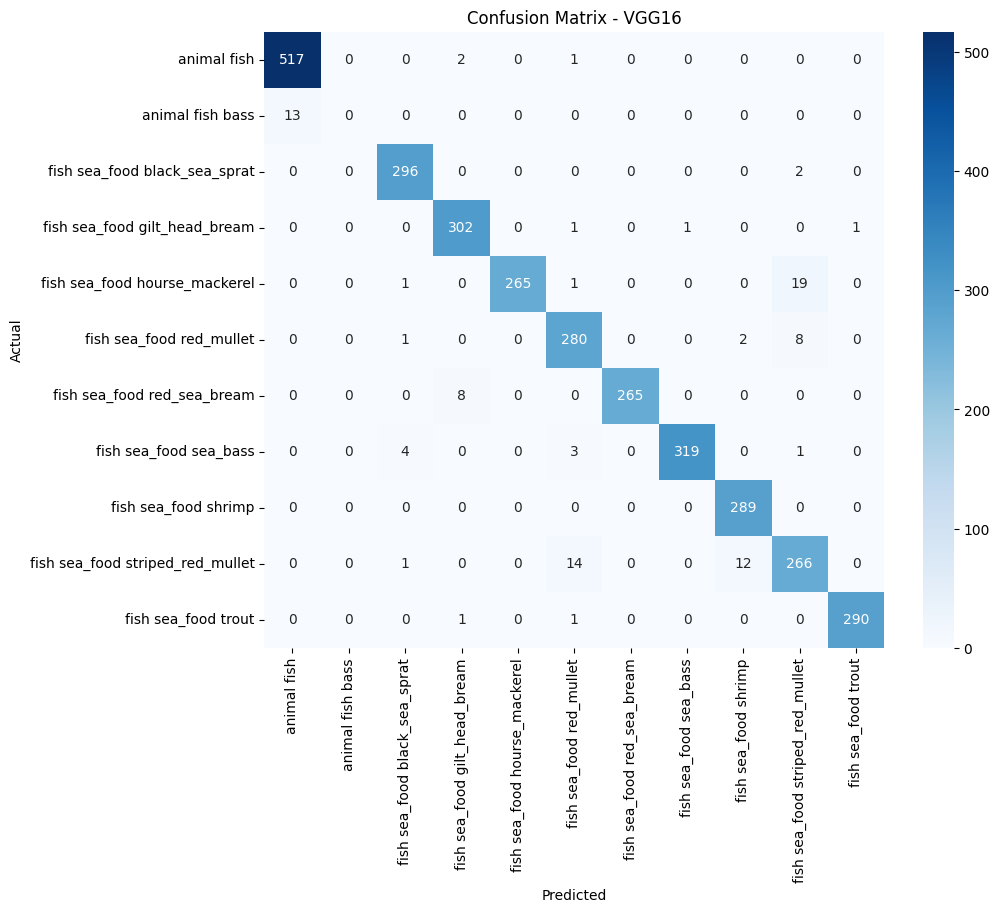

In [21]:
#Run this for each model:
evaluate_model(vgg_model, "VGG16")

 Evaluating ResNet50...
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step

Classification Report for ResNet50:

                                  precision    recall  f1-score   support

                     animal fish       0.54      0.69      0.61       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.00      0.00      0.00       298
   fish sea_food gilt_head_bream       0.50      0.01      0.01       305
   fish sea_food hourse_mackerel       0.22      0.67      0.33       286
        fish sea_food red_mullet       0.36      0.41      0.38       291
     fish sea_food red_sea_bream       0.00      0.00      0.00       273
          fish sea_food sea_bass       0.00      0.00      0.00       327
            fish sea_food shrimp       0.26      0.52      0.34       289
fish sea_food striped_red_mullet       0.31      0.10      0.15       293
             fish sea_food trout       0.27      0.58      0.37       292

    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


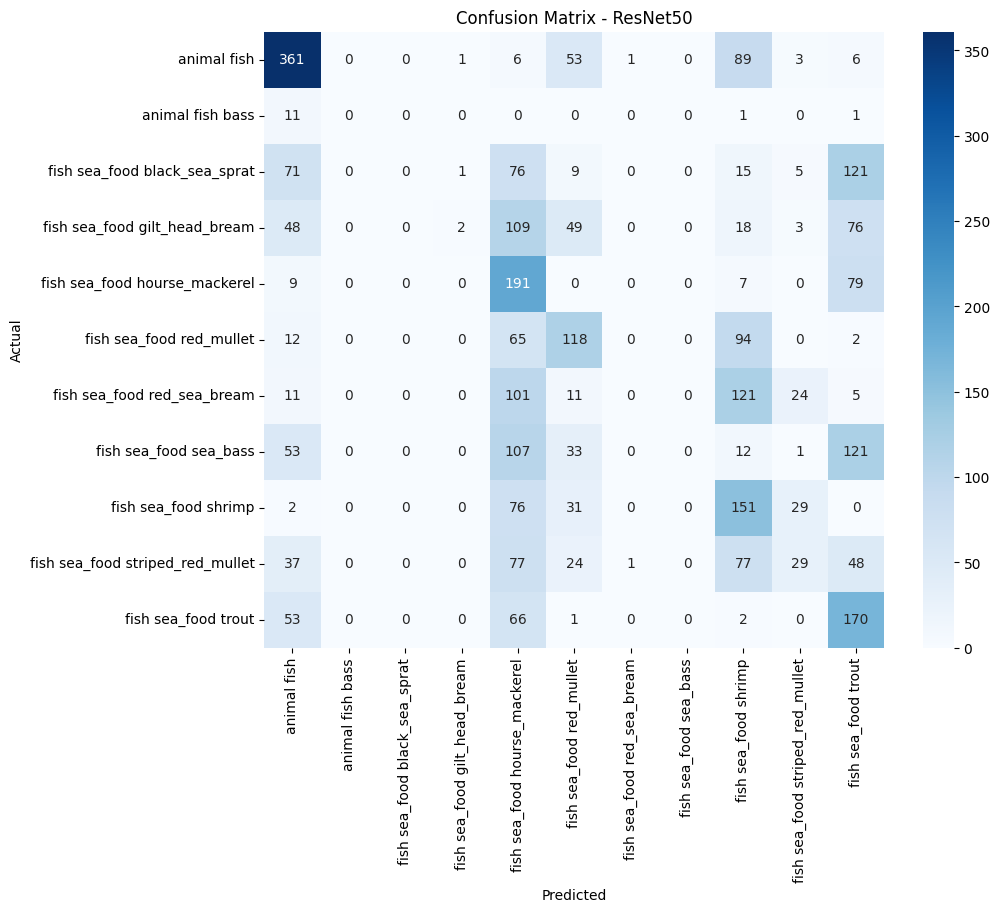

In [22]:
evaluate_model(resnet_model, "ResNet50")

 Evaluating MobileNetV2...
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step

Classification Report for MobileNetV2:

                                  precision    recall  f1-score   support

                     animal fish       1.00      1.00      1.00       520
                animal fish bass       1.00      0.85      0.92        13
   fish sea_food black_sea_sprat       1.00      1.00      1.00       298
   fish sea_food gilt_head_bream       1.00      0.99      0.99       305
   fish sea_food hourse_mackerel       1.00      1.00      1.00       286
        fish sea_food red_mullet       1.00      0.99      0.99       291
     fish sea_food red_sea_bream       0.99      1.00      0.99       273
          fish sea_food sea_bass       1.00      1.00      1.00       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       0.98      1.00      0.99       293
             fish sea_food trout       1.00      1.00      1.00       292

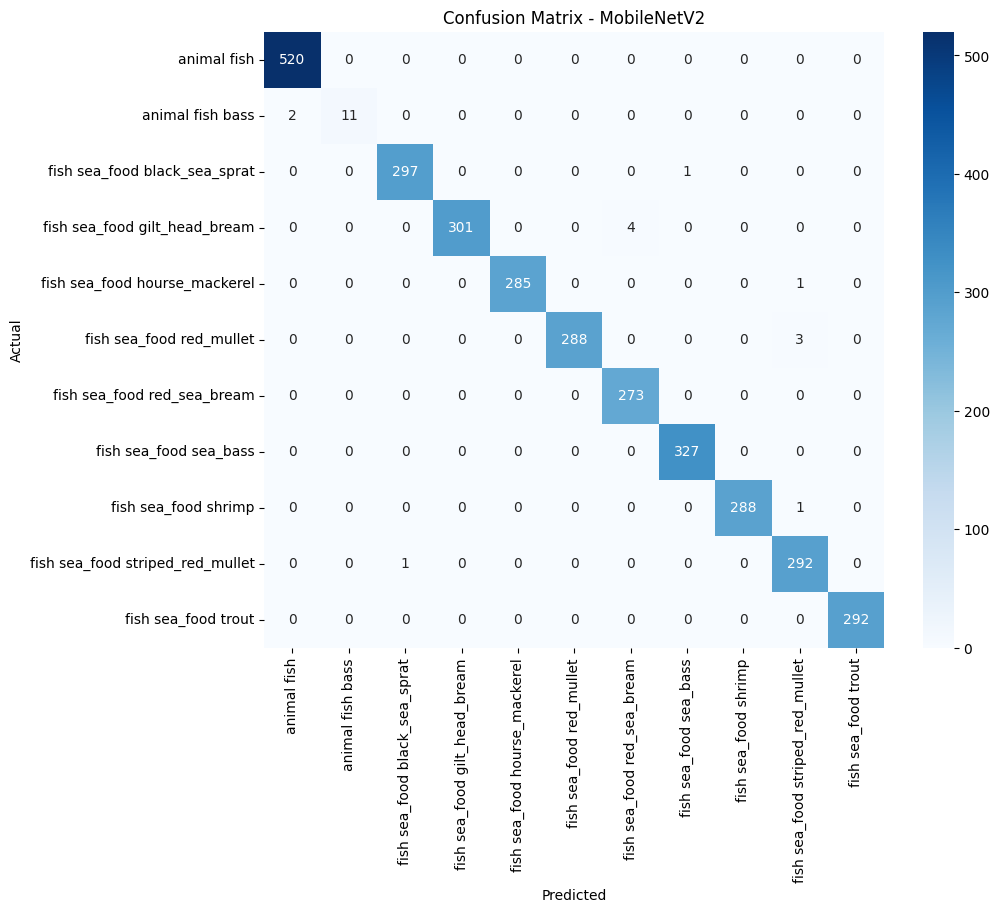

In [23]:
evaluate_model(mobilenet_model, "MobileNetV2")

 Evaluating NASNetMobile...
100/100 ━━━━━━━━━━━━━━━━━━━━ 50s 304ms/step

Classification Report for NASNetMobile:

                                  precision    recall  f1-score   support

                     animal fish       0.98      1.00      0.99       520
                animal fish bass       1.00      0.08      0.14        13
   fish sea_food black_sea_sprat       1.00      0.93      0.96       298
   fish sea_food gilt_head_bream       0.98      0.99      0.99       305
   fish sea_food hourse_mackerel       0.94      0.99      0.97       286
        fish sea_food red_mullet       0.99      0.97      0.98       291
     fish sea_food red_sea_bream       0.99      0.99      0.99       273
          fish sea_food sea_bass       0.94      0.98      0.96       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       0.96      0.92      0.94       293
             fish sea_food trout       0.98      0.99      0.99       2

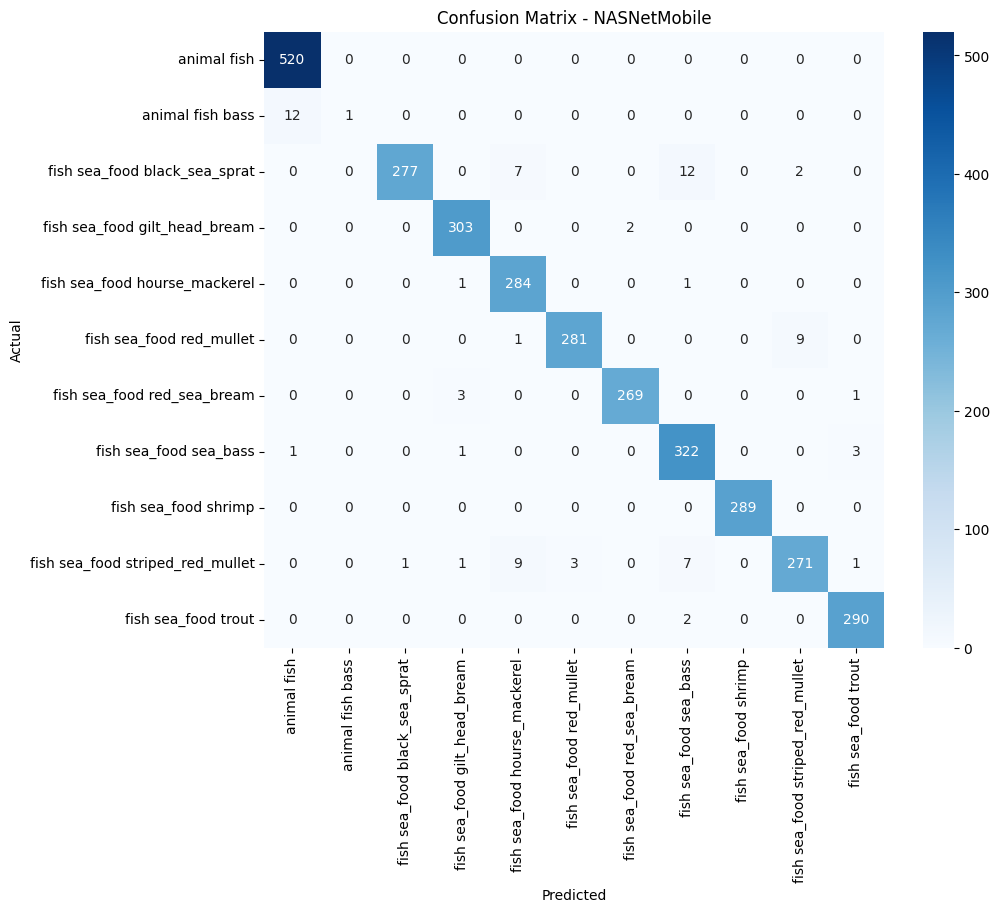

In [24]:
evaluate_model(nasnetmobile_model, "NASNetMobile")

 Evaluating EfficientNetB0...
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 148ms/step

Classification Report for EfficientNetB0:

                                  precision    recall  f1-score   support

                     animal fish       0.16      1.00      0.28       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.00      0.00      0.00       298
   fish sea_food gilt_head_bream       0.00      0.00      0.00       305
   fish sea_food hourse_mackerel       0.00      0.00      0.00       286
        fish sea_food red_mullet       0.00      0.00      0.00       291
     fish sea_food red_sea_bream       0.00      0.00      0.00       273
          fish sea_food sea_bass       0.00      0.00      0.00       327
            fish sea_food shrimp       0.00      0.00      0.00       289
fish sea_food striped_red_mullet       0.00      0.00      0.00       293
             fish sea_food trout       0.00      0.00      0.00    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


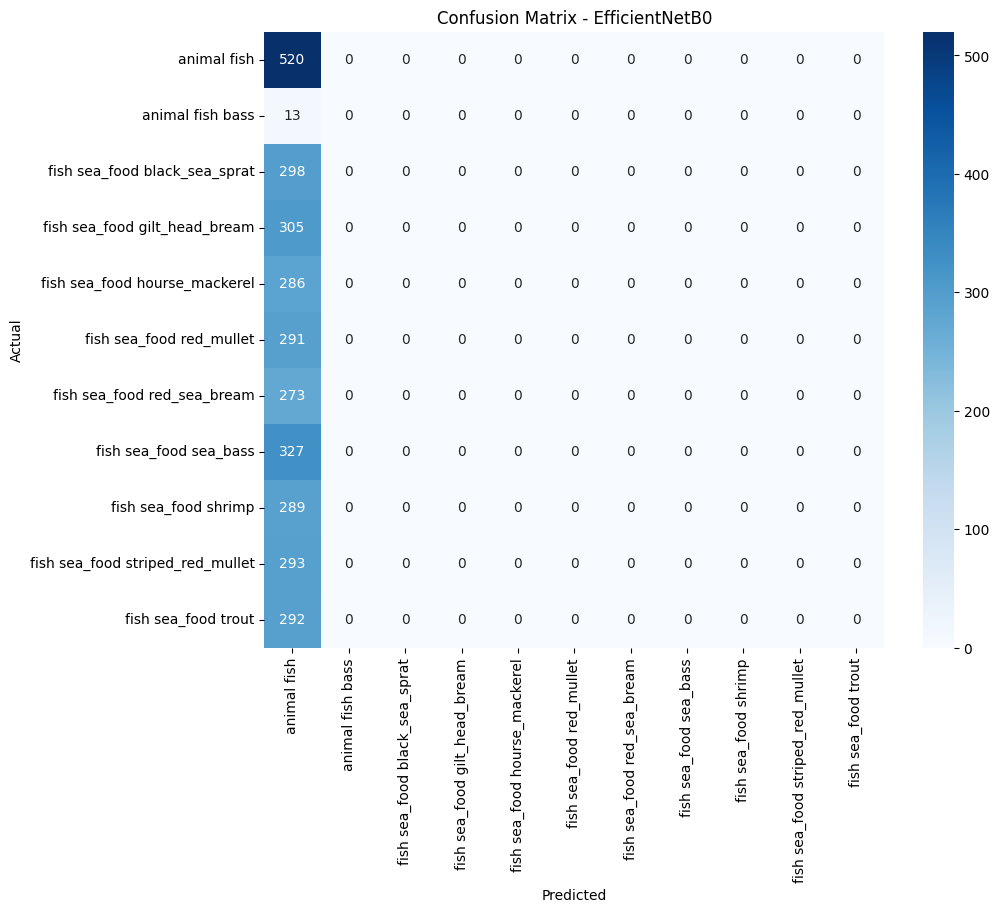

In [25]:
evaluate_model(efficientnet_model, "EfficientNetB0")

In [26]:
#2.Visualize Accuracy and Loss (Training History)
def plot_history(history, model_name):
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

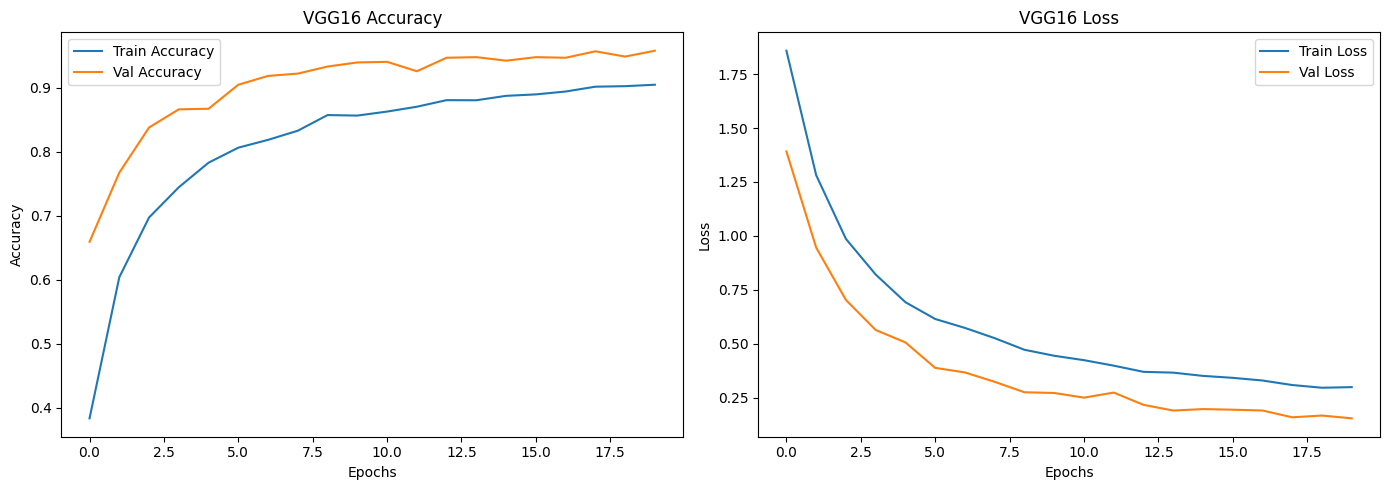

In [27]:
#Run this for each training history:
plot_history(vgg_history, "VGG16")

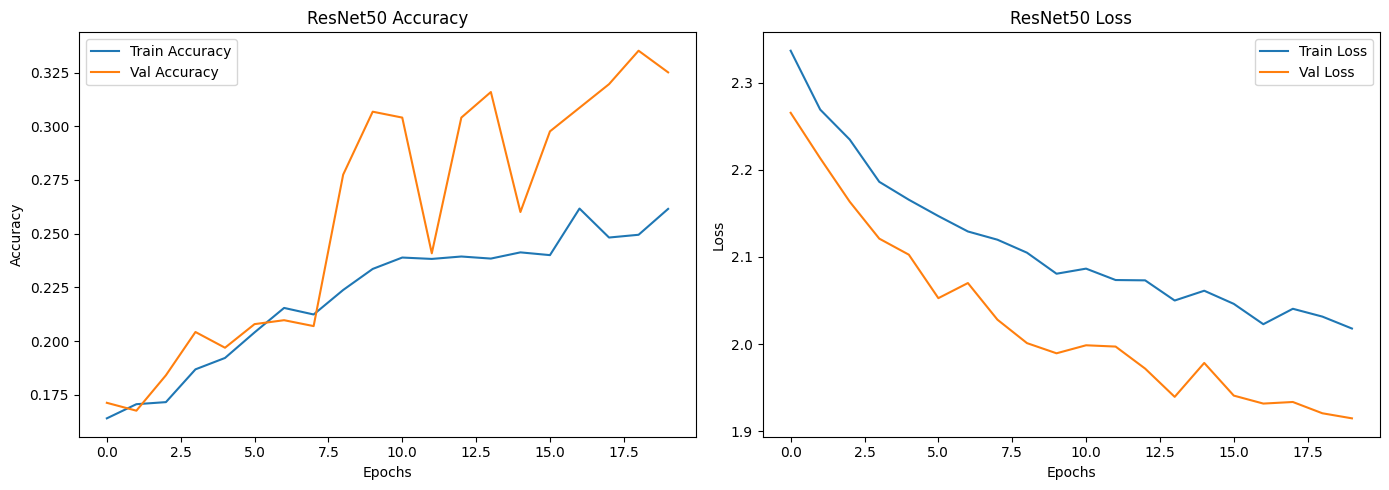

In [28]:
plot_history(resnet_history, "ResNet50")

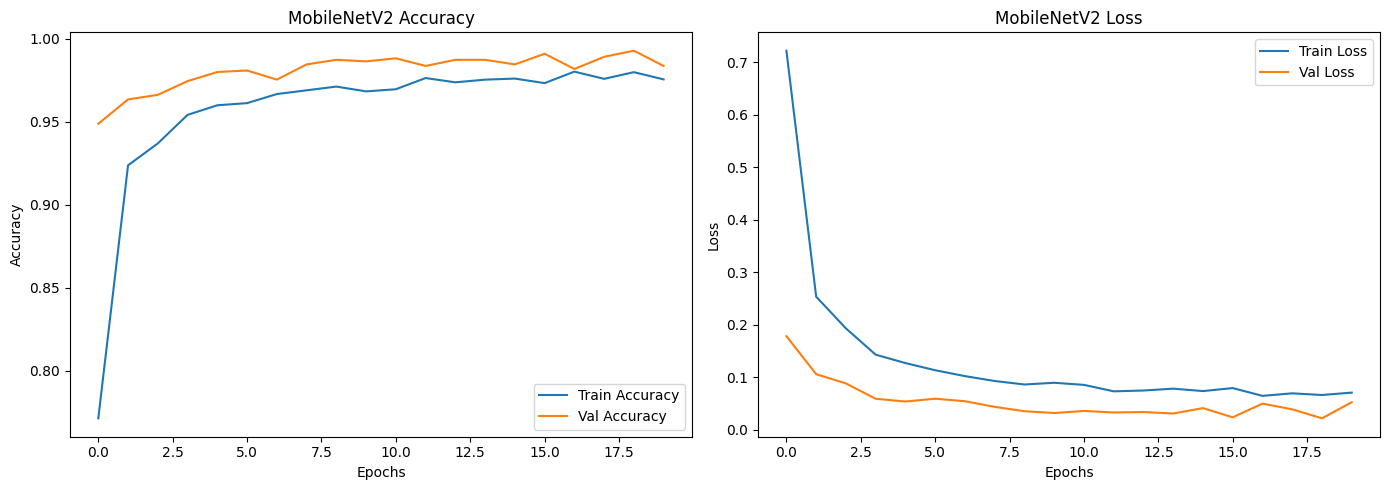

In [29]:
plot_history(mobilenet_history, "MobileNetV2")

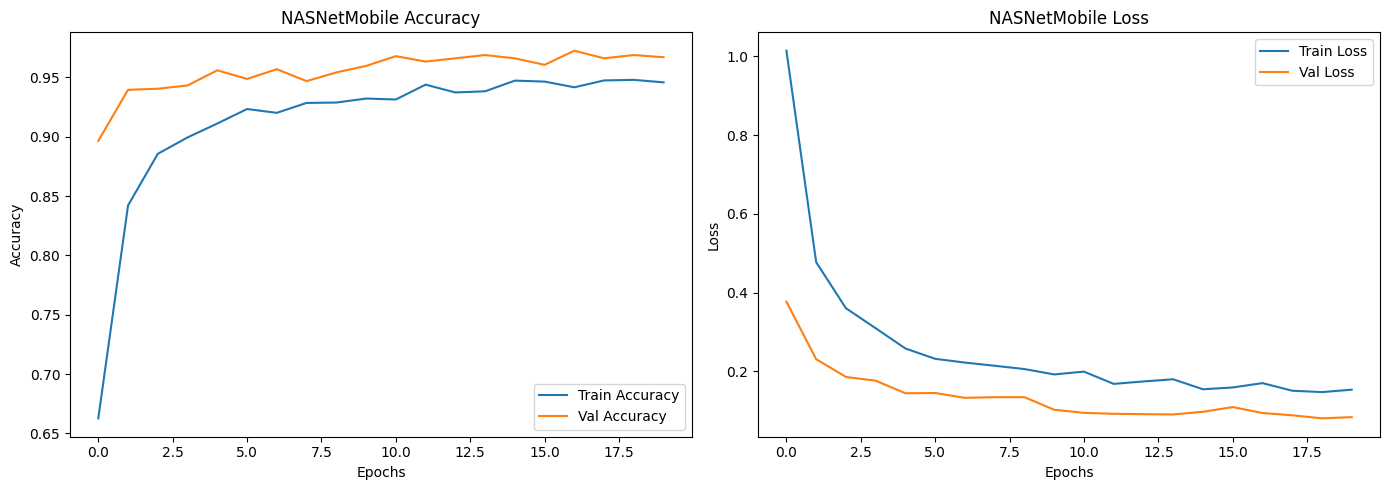

In [30]:
plot_history(nasnet_history, "NASNetMobile")

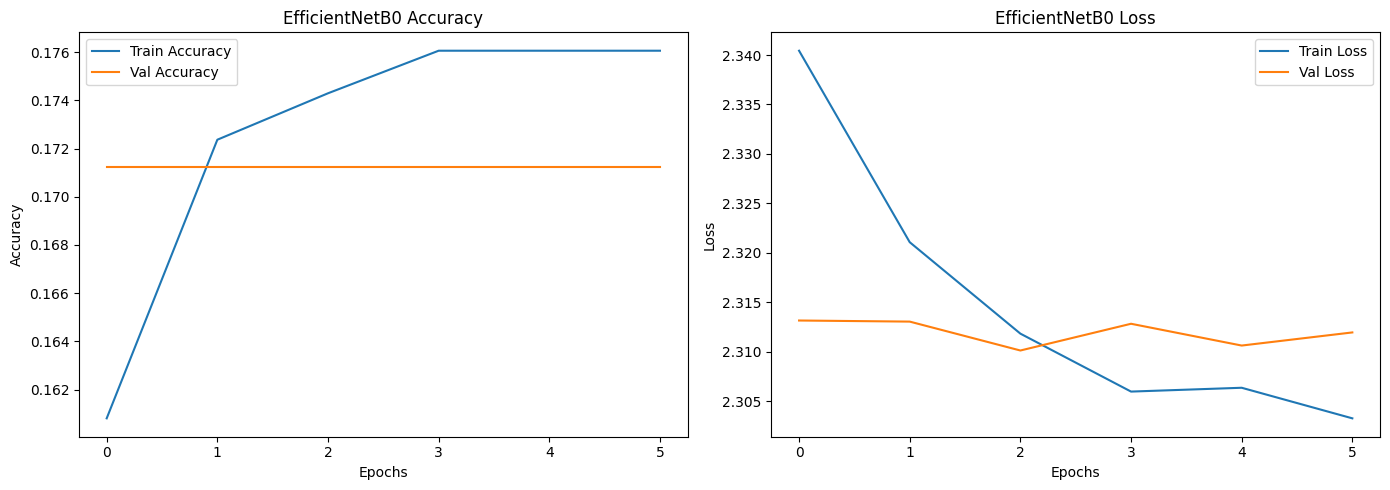

In [31]:
plot_history(efficientnet_history, "EfficientNetB0")
